## Two Moon Classification with stochastic depth

* We will take the two moon dataset as a dummy dataset that's easy to visualize, and just qualitatively see how the uncertainty boundaries differ compared to dropout.
    * IF the results look good, we'll also try to implement other methods such as Laplace Approximation for visualization

In [1]:
from functools import partial
import copy
import numpy as np
import torch
from torch import nn, optim

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision.ops import StochasticDepth
from tqdm import tqdm

from torch import Tensor
from typing import List, Tuple, Optional


### Two Moon dataset

In [2]:
def split_dataset(X, Y, train_ratio=0.8):
    n = len(X)
    n_train = int(n * train_ratio)
    indices = torch.randperm(n)
    train_indices, test_indices = indices[:n_train], indices[n_train:]
    X_train, Y_train = X[train_indices], Y[train_indices]
    X_test, Y_test = X[test_indices], Y[test_indices]

    return X_train, Y_train, X_test, Y_test


def plot_two_moons(X, Y):
    plt.figure(figsize=(5, 5))
    for i in range(len(X)):
        plt.scatter(X[i, 0], X[i, 1], c="orange" if Y[i] == 1 else "green")
    # plt.axis("off")


X, Y = make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=1)
X, Y = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

# plot_two_moons(X, Y)

### Bayesian Network Wrapper Class

In [139]:
class BayesianNet(nn.Module):
    """
    Bayesian network class has two internal states, dropout_state and stochastic_depth_state.
    They overwrite the default behaviour of forward pass to enable switching between bayesian and deterministic modes.
    Toggling the states is done by calling set_bayes_mode method.
    """

    def __init__(self) -> None:
        super().__init__()
        self.dropout_state: bool = False
        self.stochastic_depth_state: bool = False
        self.use_subnet = False  # determines behaviour at inference
        self.generator = None
        self._seed = 0

    def sample_subnet(self) -> None:
        self.generator = torch.Generator()
        self._seed = torch.randint(low=0, high=10000, size=(1,)).item()

    def _toggle_dropout(self) -> None:
        # override the default behaviour of dropout layers
        if self.dropout_state:
            for m in self.modules():
                if m.__class__.__name__.startswith("Dropout"):
                    m.train()

    def _toggle_stochastic_depth(self) -> None:
        # override the default behaviour of stochastic depth layers
        if self.stochastic_depth_state:
            for m in self.modules():
                if m.__class__.__name__.startswith("StochasticDepth"):
                    m.train()

    def _set_dropout(self, state: bool) -> None:
        self.dropout_state = state

    def _set_stochastic_depth(self, state: bool) -> None:
        self.stochastic_depth_state = state

    def set_bayes_mode(self, state: bool, mode: str) -> None:
        if mode == "do":
            self._set_dropout(state)
        elif mode == "sd":
            self._set_stochastic_depth(state)
        else:
            print(f"Mode {mode} is not supported.")

    def forward(self, x: Tensor) -> Tensor:
        if self.use_subnet and self.generator:
            self.generator.manual_seed(self.generator_seed)
        self._toggle_stochastic_depth()
        self._toggle_dropout()

        return self._forward_impl(x)

    def _forward_impl(self, x: Tensor) -> Tensor:
        raise NotImplementedError

### Custom stochastic regularization layers
Write my own dropout & sd layers that can take deterministic states for sampling subnets

In [140]:
class DropoutCustom(nn.Module):
    def __init__(self, p: float = 0.5):
        assert 0 <= p <= 1
        super().__init__()
        self.p = p

    def forward(self, x: Tensor, generator: Optional[torch.Generator] = None) -> Tensor:
        if not self.training or self.p == 0.0:
            return x
        if generator:
            noise = (
                torch.empty(x.shape[1:], device=x.device)
                .bernoulli_(1 - self.p, generator=generator)
                .unsqueeze(dim=0)
            )
        else:
            noise = torch.empty_like(x).bernoulli_(1 - self.p, generator=generator)
        noise = noise.div_(1 - self.p)
        return noise * x


class StochasticDepthCustom(nn.Module):
    def __init__(self, p: float = 0.5, mode="row"):
        assert 0 <= p <= 1
        super().__init__()
        self.p = p
        self.mode = mode

    def forward(self, x: Tensor, generator: Optional[torch.Generator] = None) -> Tensor:
        if not self.training or self.p == 0.0:
            return x

        survival_rate = 1.0 - self.p
        if self.mode == "row":
            size = [x.shape[0]] + [1] * (x.ndim - 1)
        else:
            size = [1] * x.ndim
        if generator:
            size = [1]
        noise = torch.empty(size, dtype=x.dtype, device=x.device)
        noise = noise.bernoulli_(survival_rate, generator=generator)
        if survival_rate > 0.0:
            noise.div_(survival_rate)
        return x * noise

### A simple residual network

In [141]:
class _ResidualSdBlock(nn.Module):
    """Implements a simple x + lin(x) block"""

    def __init__(self, features: int, p: float = 0.5) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features), nn.BatchNorm1d(features), nn.ReLU()
        )
        self.p = p
        self.sd = StochasticDepthCustom(p, mode="row")

    def forward(self, x: Tensor, generator=None) -> Tensor:
        out = self.block(x)
        out = self.sd(out, generator)
        # apply skip connection
        out = x + out
        return out


class SdNetwork(BayesianNet):
    def __init__(self, inp: int, oup: int, N: int, d_feat: int, p=0.5):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(inp, d_feat),
            nn.BatchNorm1d(d_feat),
            nn.ReLU(),
            *[_ResidualSdBlock(d_feat, p=p) for _ in range(N)],
            nn.Linear(d_feat, oup),
            nn.Softmax(dim=-1)
        )

    def _forward_impl(self, x: Tensor) -> Tensor:
        generator = self.generator if self.use_subnet else None
        for block in self.blocks:
            if type(block) == _ResidualSdBlock:
                x = block(x, generator)
            else:
                x = block(x)
        return x

### A simple dropout network

In [142]:
class _ResidualDropoutBlock(nn.Module):
    """Implements a simple dropout(lin(x)) block"""

    def __init__(self, features: int, p: float = 0.5) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(features, features),
            nn.BatchNorm1d(features),
            nn.ReLU(),
        )
        self.dropout = DropoutCustom(p=p)

    def forward(self, x: Tensor, generator=None) -> Tensor:
        out = self.dropout(self.block(x), generator)
        # apply skip connection
        out = x + out
        return out


class DONetwork(BayesianNet):
    def __init__(self, inp: int, oup: int, N: int, d_feat: int, p=0.5):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(inp, d_feat),
            nn.BatchNorm1d(d_feat),
            nn.ReLU(),
            *[_ResidualDropoutBlock(d_feat, p=p) for _ in range(N)],
            nn.Linear(d_feat, oup),
            nn.Softmax(dim=-1)
        )

    def _forward_impl(self, x: Tensor) -> Tensor:
        generator = self.generator if self.use_subnet else None
        for block in self.blocks:
            if type(block) == _ResidualDropoutBlock:
                x = block(x, generator)
            else:
                x = block(x)
        return x

### Bayesian forward pass

In [143]:
def bayes_forward(x: Tensor, net: BayesianNet, mode: str, T: int) -> Tensor:
    net.eval()
    net.set_bayes_mode(True, mode)
    with torch.no_grad():
        y_logits_samples = net(x.repeat(T, 1))
        y_logits = y_logits_samples.mean(dim=0)

    return y_logits


def batch_bayes_forward(
    x_batch: Tensor, net: BayesianNet, mode: str, T: int, use_subnet: bool = False
) -> Tensor:
    """
    Performs bayesian forward pass in eval mode for a batch of input
    Args
    - net
    - x_batch: tensor with shape (n, m) containing n samples of m dimensional inputs
    - mode: 'dropout' or 'sd'
    - T: number of stochastic samples

    Returns
    - y_logits_batch: tensor with shape (n, c)
    """
    net.eval()
    net.set_bayes_mode(True, mode)
    net.use_subnet = use_subnet

    n = x_batch.shape[0]

    with torch.no_grad():
        if use_subnet:
            net.sample_subnet()
            y_logits = net(x_batch)  # n x c
            y_logits_samples = torch.empty(T, *y_logits.shape)  # T x n x c
            y_logits_samples[0, :] = y_logits
            # iterate over the rest of the subnets
            for i in range(T - 1):
                net.sample_subnet()
                y_logits_samples[i + 1, :] = net(x_batch)
        elif not use_subnet:
            y_logits_samples = net(x_batch.repeat(T, 1))  # (Txn, m)
            y_logits_samples = y_logits_samples.reshape((T, n, -1))

    return y_logits_samples.mean(dim=0)


def batch_ensemble_forward(x_batch: Tensor, nets: List[nn.Module]) -> Tensor:
    for net in nets:
        net.eval()
    T = len(nets)
    # use the first network to determine the shape of the output
    y_logits = net(x_batch)  # n x c
    y_logits_samples = torch.empty(T, *y_logits.shape)  # T x n x c
    y_logits_samples[0, :] = y_logits
    # iterate over the rest of the network
    for i, net in enumerate(nets[1:]):
        y_logits_samples[i + 1, :] = net(x_batch)

    return y_logits_samples.mean(dim=0)  # n x c

### Train DO & sd networks

100%|██████████| 500/500 [00:04<00:00, 107.20it/s]


Accuracy: 0.955
Accuracy: 0.960


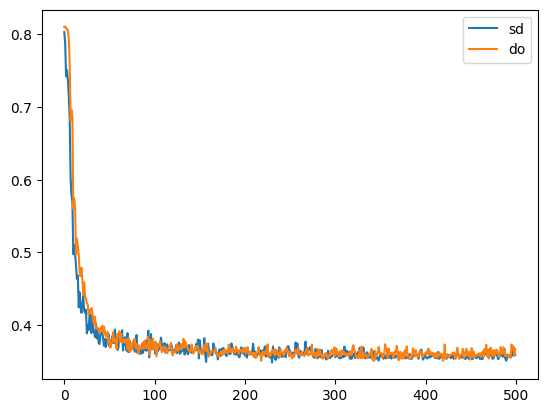

In [195]:
# net:BayesianNet = DONetwork(inp=2, oup=2, N=2, d_feat=30, p=0.5)
do_net: BayesianNet = DONetwork(inp=2, oup=2, N=20, d_feat=10, p=0.2)
sd_net: BayesianNet = SdNetwork(inp=2, oup=2, N=20, d_feat=10, p=0.2)


def train(net, epochs) -> List[float]:
    net.train()
    optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-5)
    # criterion = nn.BCELoss()
    criterion = nn.CrossEntropyLoss()

    history = []

    for e in tqdm(range(epochs)):
        optimizer.zero_grad()
        y_logits = net(X)
        loss = criterion(y_logits.squeeze(1), Y.to(torch.long))
        loss.backward()
        optimizer.step()

        history.append(loss.item())

    return history


history = train(sd_net, 500)
plt.plot(history, label='sd')
history = train(do_net, 500)
plt.plot(history, label='do')
plt.legend()


def eval(net):
    net.eval()
    with torch.no_grad():
        net.set_bayes_mode(False, "sd")
        y_pred = net(X).argmax(dim=1)
    return (y_pred.squeeze() == Y).sum() / len(Y)


# plot_two_moons(X, y_pred)

print(f"Accuracy: {eval(do_net):.3f}")
print(f"Accuracy: {eval(sd_net):.3f}")

### Train an ensemble of networks

In [148]:
nets: List[nn.Module] = []
T = 10
for i in range(T):
    net = SdNetwork(inp=2, oup=2, N=10, d_feat=10, p=0)
    net.generator=None
    _ = train(net, 100)
    net.eval()
    nets.append(copy.deepcopy(net))
    del net

100%|██████████| 100/100 [00:00<00:00, 184.64it/s]


### Qualitative view of confidence scores

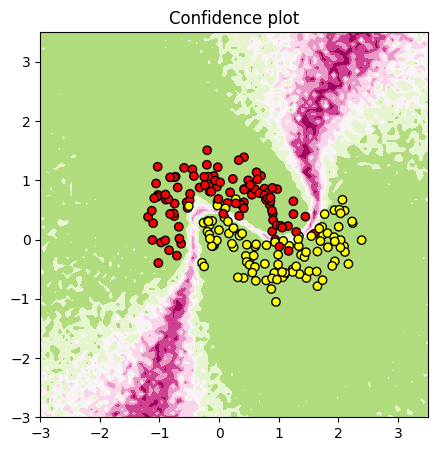

In [197]:
def compute_confidence(inp, forward_func, batch_size) -> Tensor:
    """Computes confidence score over the entire inp, handles batching"""
    py = torch.empty((len(inp)), dtype=torch.float)
    y_pred = torch.empty((len(inp)), dtype=torch.long)
    b = batch_size
    for i in range(0, inp.shape[0], b):
        logits = forward_func(inp[i : i + b])
        p, y = torch.max(logits, dim=-1)
        py[i : i + b] = p
        y_pred[i : i + b] = y
    return py, y_pred


def plot_confidence(forward_func, grid_size=100, batch_size=10):
    XX, YY = np.meshgrid(
        np.linspace(-3, 3.5, grid_size), np.linspace(-3, 3.5, grid_size)
    )
    with torch.no_grad():
        inp = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
        py, _ = compute_confidence(inp, forward_func, batch_size)

    ZZ = py.reshape(XX.shape)
    plt.contourf(XX, YY, ZZ, cmap="PiYG", vmin=0.5, vmax=1.2)
    # plt.colorbar(ticks=np.linspace(0.5, 1, 6))
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="autumn", edgecolor="k")
    plt.title("Confidence plot")


# forward_func = partial(batch_ensemble_forward, nets=nets)
forward_func = partial(
    batch_bayes_forward, net=sd_net, mode="sd", T=30, use_subnet=False
)
forward_func = partial(
    batch_bayes_forward, net=do_net, mode="do", T=30, use_subnet=False
)
plt.figure(figsize=(5, 5))
plot_confidence(forward_func, grid_size=100, batch_size=100)

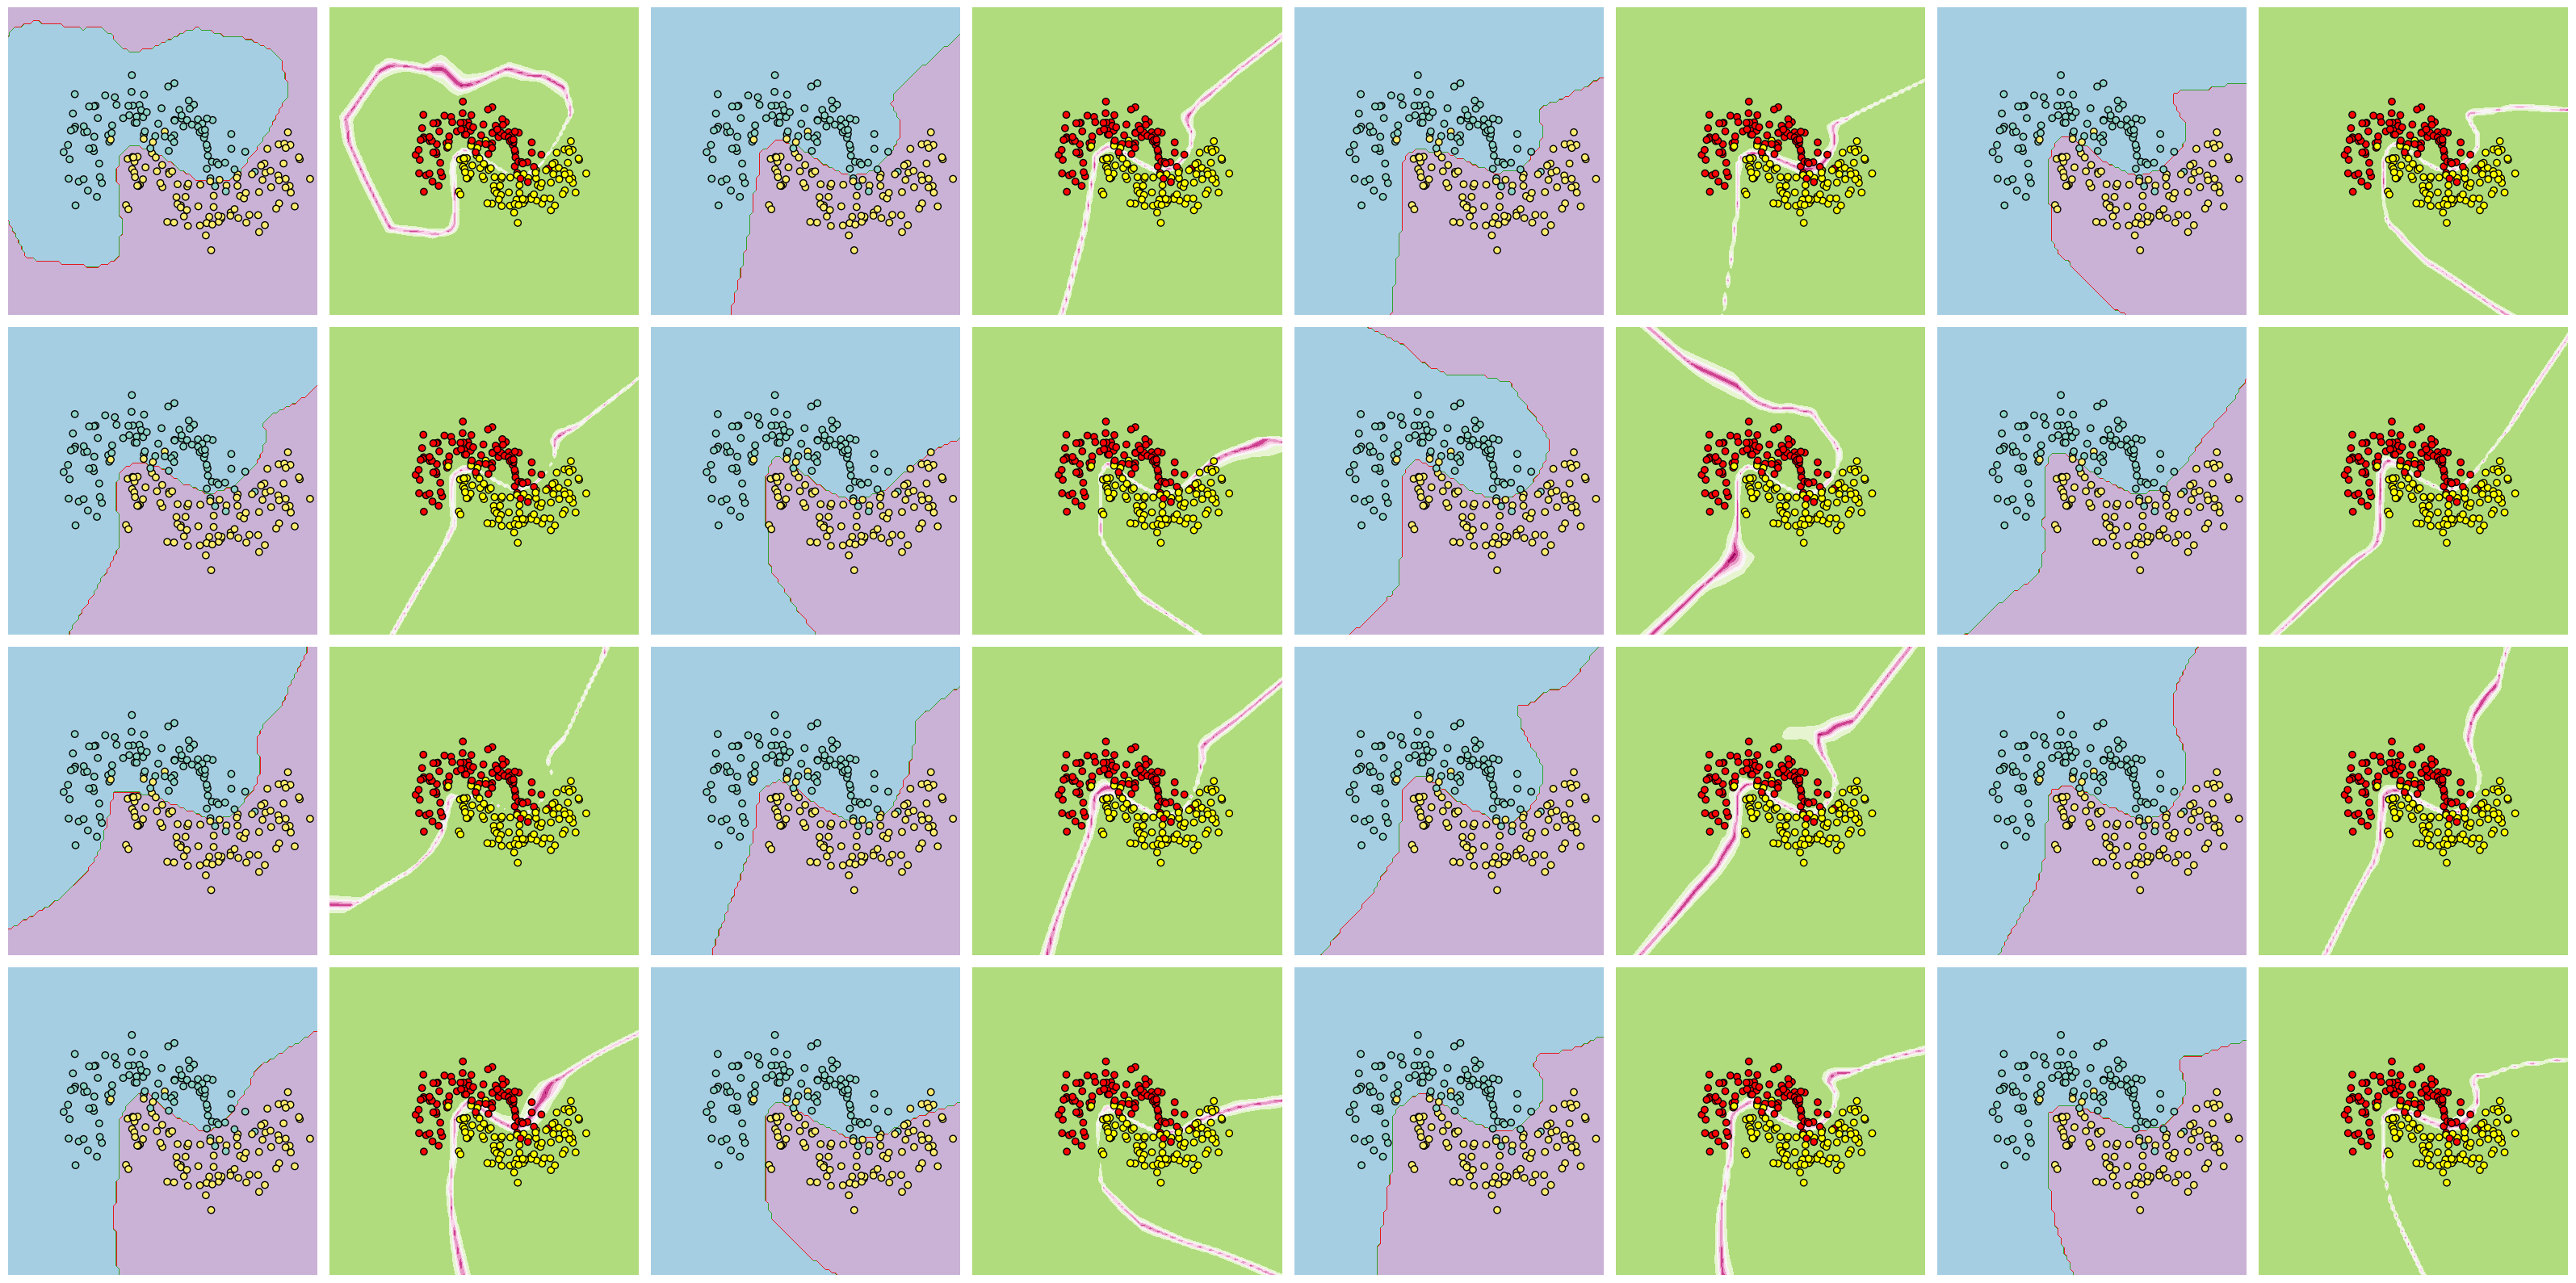

In [188]:
def plot_decision_boundary(forward_func, grid_size=100, batch_size=10):
    XX, YY = np.meshgrid(
        np.linspace(-2, 2.5, grid_size), np.linspace(-2, 2.5, grid_size)
    )
    with torch.no_grad():
        inp = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
        py, pred = compute_confidence(inp, forward_func, batch_size)

    ZZ = pred.reshape(XX.shape).to(torch.int)
    plt.contourf(XX, YY, ZZ, cmap="Paired", vmin=0.5, vmax=1.2, antialiased=False)
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap="Set3", edgecolor="k")
    plt.axis("off")


def plot_sample_network_decision_boundaries(net, grid=(2, 3)):
    plt.figure(figsize=(grid[1] * 4, grid[0] * 4))
    net.eval()
    net.set_bayes_mode(True, "sd")
    net.set_bayes_mode(True, "do")
    net.use_subnet = True

    with torch.no_grad():
        for i in range(0, grid[0] * grid[1], 2):
            net.sample_subnet()
            plt.subplot(*grid, i + 1)
            plot_decision_boundary(net.forward, grid_size=100, batch_size=1000)
            plt.subplot(*grid, i + 2)
            plot_confidence(net.forward, 100, 1000)
            plt.axis("off")
            plt.title("")
    plt.tight_layout()


plot_sample_network_decision_boundaries(do_net, (4, 8))

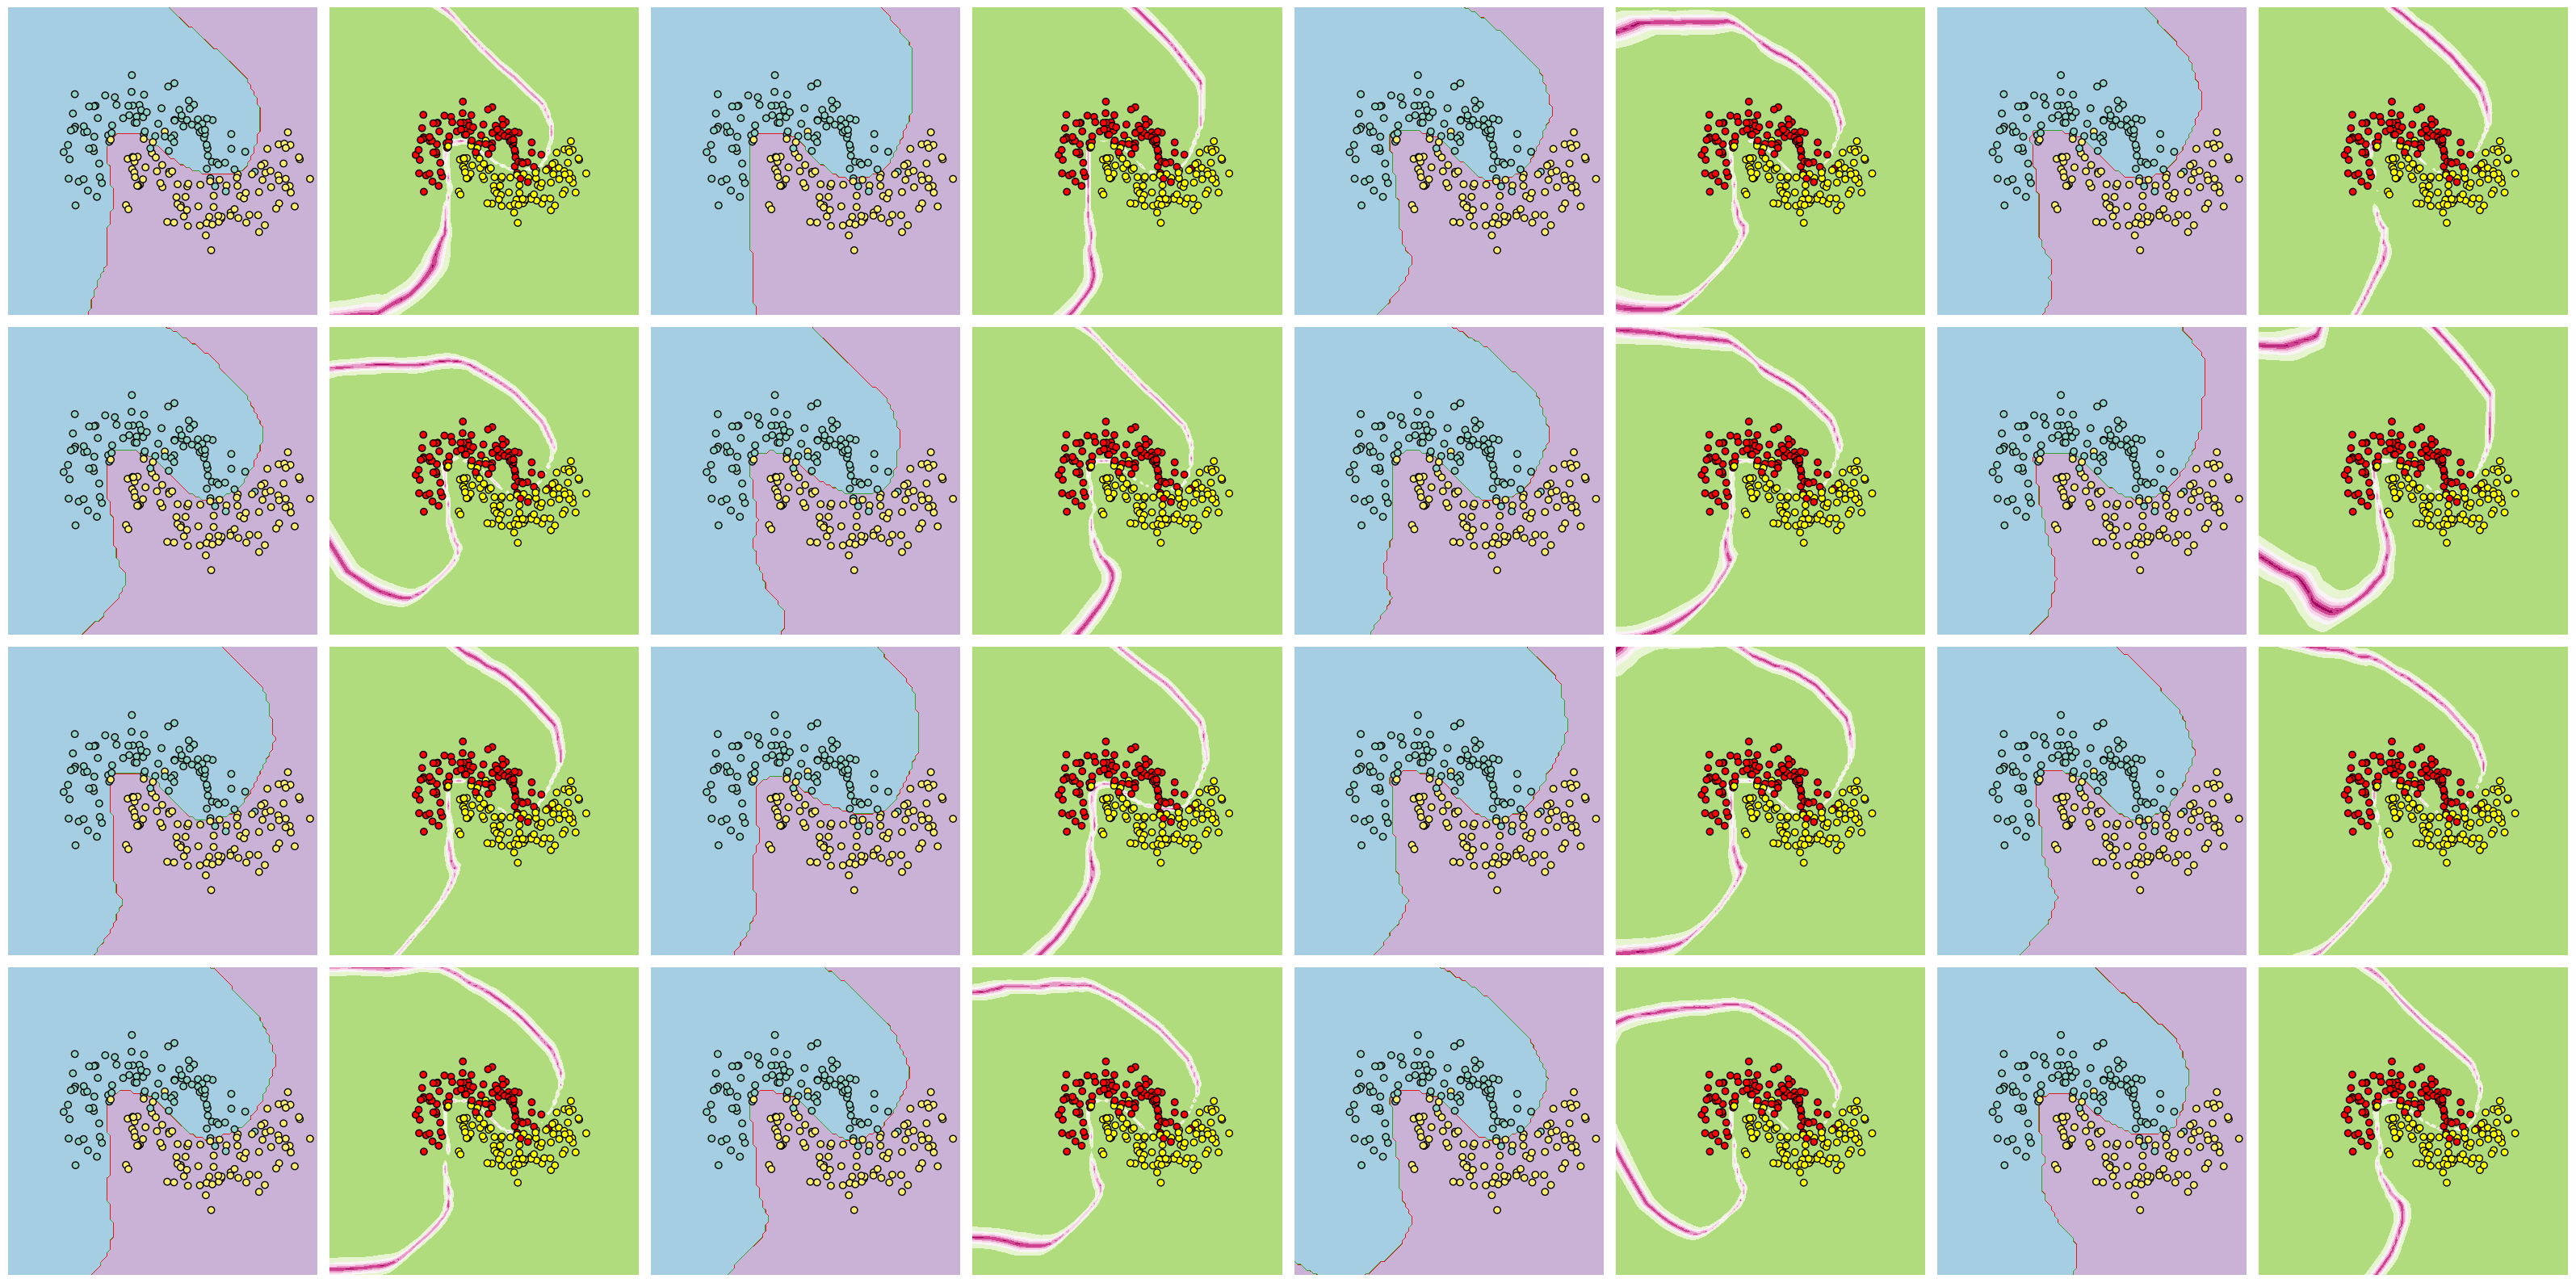

In [192]:
plot_sample_network_decision_boundaries(sd_net, (4, 8))